In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense

##  Load the Dataset

In [2]:
df=pd.read_csv('/content/Dataset.csv')
df.head()

,gender,SeniorCitizen,Dependents,tenure,PhoneService,MultipleLines,InternetService,Contract,MonthlyCharges,Churn
0,Female,0,No,1,No,No,DSL,Month-to-month,29.85,No
1,Male,0,No,34,Yes,No,DSL,One year,56.95,No
2,Male,0,No,2,Yes,No,DSL,Month-to-month,53.85,Yes
3,Male,0,No,45,No,No,DSL,One year,42.30,No
4,Female,0,No,2,Yes,No,Fiber optic,Month-to-month,70.70,Yes


## Data Preprocessing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           7043 non-null   object 
 1   SeniorCitizen    7043 non-null   int64  
 2   Dependents       7043 non-null   object 
 3   tenure           7043 non-null   int64  
 4   PhoneService     7043 non-null   object 
 5   MultipleLines    7043 non-null   object 
 6   InternetService  7043 non-null   object 
 7   Contract         7043 non-null   object 
 8   MonthlyCharges   7043 non-null   float64
 9   Churn            7043 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 550.4+ KB


In [4]:
df.dtypes

,0
gender,object
SeniorCitizen,int64
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
Contract,object
MonthlyCharges,float64
Churn,object


In [5]:
def print_unique_col_values(df):
    """Print unique values from categorical columns of the given dataframe"""
    print('Unique values from categorical columns,\n')
    for column in df.columns:
        if(df[column].dtypes == 'object'):
            print(f'column: {column}, Unique vlaues: {df[column].unique()}')

print_unique_col_values(df)

Unique values from categorical columns,

column: gender, Unique vlaues: ['Female' 'Male']
column: Dependents, Unique vlaues: ['No' 'Yes']
column: PhoneService, Unique vlaues: ['No' 'Yes']
column: MultipleLines, Unique vlaues: ['No' 'Yes']
column: InternetService, Unique vlaues: ['DSL' 'Fiber optic']
column: Contract, Unique vlaues: ['Month-to-month' 'One year' 'Two year']
column: Churn, Unique vlaues: ['No' 'Yes']


In [6]:

# Binary Encoding for 'Yes/No' and 'Female/Male' columns
binary_columns = ['gender', 'Dependents', 'PhoneService', 'MultipleLines', 'Churn']
for column in binary_columns:
    df[column] = df[column].map({'Female': 0, 'Male': 1, 'No': 0, 'Yes': 1})

# One-Hot Encoding for columns with more than two unique values
df = pd.get_dummies(df, columns=['InternetService', 'Contract'], drop_first=True)

# Display the first few rows to verify the encoding
df.head()

,gender,SeniorCitizen,Dependents,tenure,PhoneService,MultipleLines,MonthlyCharges,Churn,InternetService_Fiber optic,Contract_One year,Contract_Two year
0,0,0,0,1,0,0,29.85,0,False,False,False
1,1,0,0,34,1,0,56.95,0,False,True,False
2,1,0,0,2,1,0,53.85,1,False,False,False
3,1,0,0,45,0,0,42.30,0,False,True,False
4,0,0,0,2,1,0,70.70,1,True,False,False


In [7]:
df.columns

Index(['gender', 'SeniorCitizen', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'MonthlyCharges', 'Churn',
       'InternetService_Fiber optic', 'Contract_One year',
       'Contract_Two year'],
      dtype='object')

In [8]:
# Split features and target variable
X = df.drop('Churn', axis=1)  # Features
y = df['Churn']  # Target

# Normalize numerical features for better ANN performance
scaler = StandardScaler()
X[['tenure', 'MonthlyCharges']] = scaler.fit_transform(X[['tenure', 'MonthlyCharges']])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

# Lets have a look at our training datatset
X_train.sample(5)

X_train: (5634, 10), y_train: (5634,)
X_test: (1409, 10), y_test: (1409,)


,gender,SeniorCitizen,Dependents,tenure,PhoneService,MultipleLines,MonthlyCharges,InternetService_Fiber optic,Contract_One year,Contract_Two year
174,0,0,0,-0.015113,1,0,-1.469417,False,True,False
4556,1,0,0,-1.236724,1,0,0.099319,True,False,False
5409,0,1,0,-0.259435,1,1,0.810568,True,False,False
3667,0,1,1,-0.340876,1,0,1.056514,True,False,True
6066,1,0,0,-1.236724,1,0,1.003337,True,False,False


# model Building
## Train the ANN Model



In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
import numpy as np

def create_enhanced_model(neurons=32, learning_rate=0.001, dropout_rate=0.0):
    model = Sequential()

    # Input layer with first hidden layer
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))  # Regularization

    # Second hidden layer
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))

    # Third hidden layer
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Define hyperparameter space for tuning
param_grid = {
    'neurons': [16, 32, 64],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'dropout_rate': [0.0, 0.3, 0.5],
}

# Create a custom scorer for F1 score
f1_scorer = make_scorer(f1_score)

# Sample function to use for hyperparameter tuning without KerasClassifier
def run_random_search(X_train, y_train, param_grid, n_iter=10):
    best_f1 = 0
    best_params = None
    for _ in range(n_iter):
        params = {k: np.random.choice(v) for k, v in param_grid.items()}
        model = create_enhanced_model(**params)
        model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
        y_pred = (model.predict(X_test) > 0.5).astype("int32")
        current_f1 = f1_score(y_test, y_pred)
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_params = params
    return best_params, best_f1

# Run hyperparameter tuning
best_params, best_f1 = run_random_search(X_train, y_train, param_grid)
print(f"Best parameters: {best_params}")
print(f"Best F1 score: {best_f1:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best parameters: {'neurons': 16, 'learning_rate': 0.0005, 'dropout_rate': 0.0}
Best F1 score: 0.62


In [11]:
# Step 5: Train the final model with the best parameters
final_model = create_enhanced_model(**best_params)
history1= final_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5618 - loss: 0.6683
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7369 - loss: 0.5224
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7897 - loss: 0.4496
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7867 - loss: 0.4385
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7996 - loss: 0.4263
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7959 - loss: 0.4272
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7880 - loss: 0.4281
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7899 - loss: 0.4335
Epoch 9/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7959 - loss: 0.4342
Epoch 10/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7983 - loss: 0.4200
Epoch 11/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7940 - loss: 0.4238
Epoch 12/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Calculate metrics
# Evaluate the model
y_pred = (final_model.predict(X_test) > 0.4).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation results
print(f"Enhanced Model Metrics:\nAccuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}")


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Enhanced Model Metrics:
Accuracy: 0.80
Precision: 0.61
Recall: 0.63
F1 Score: 0.62


## fine tuning

In [18]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the advanced model architecture
def create_advanced_model():
    model = Sequential()

    # First hidden layer with batch normalization
    model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Second hidden layer
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # Third hidden layer
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Fourth hidden layer
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with a lower learning rate for more stable convergence
    optimizer = Adam(learning_rate=0.0003)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the advanced model
advanced_model = create_advanced_model()

# Use a learning rate scheduler to reduce the learning rate if the model's performance plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)


# Train the model with the learning rate scheduler callback
history = advanced_model.fit(X_train, y_train, epochs=60, batch_size=32, verbose=1,
                             validation_data=(X_test, y_test), callbacks=[reduce_lr])

# Evaluate the advanced model
y_pred = (advanced_model.predict(X_test) > 0.4).astype("int32")

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation results
print(f"Advanced Model Metrics:\nAccuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6369 - loss: 0.6722 - val_accuracy: 0.7353 - val_loss: 0.5030 - learning_rate: 3.0000e-04
Epoch 2/60
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7369 - loss: 0.5300 - val_accuracy: 0.7594 - val_loss: 0.4398 - learning_rate: 3.0000e-04
Epoch 3/60
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7506 - loss: 0.5112 - val_accuracy: 0.8013 - val_loss: 0.4126 - learning_rate: 3.0000e-04
Epoch 4/60
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7697 - loss: 0.4807 - val_accuracy: 0.8077 - val_loss: 0.4090 - learning_rate: 3.0000e-04
Epoch 5/60
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7762 - loss: 0.4888 - val_accuracy: 0.8034 - val_loss: 0.4097 - learning_rate: 3.0000e-04
Epoch 6/60
177/177 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7577 - loss: 0.4870 - val_accuracy: 0.8006 - val_loss: 0.4107 - learning_rate: 3.0000e-04
Epoch 7/60
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 

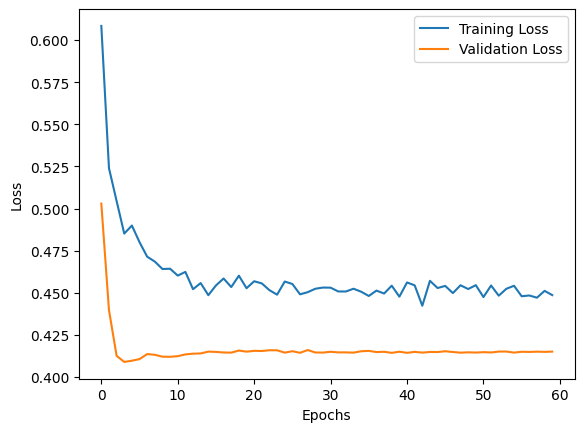

In [19]:
import matplotlib.pyplot as plt
import shap
# Example: Saving training history plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


## Interpreting the results from the model, identifying key factors influencing customer churn.

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
45000/45000 ━━━━━━━━━━━━━━━━━━━━ 86s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
45000/45000 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
45000/45000 ━━━━━━━━━━━━━━━━━━━━ 96s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
45000/45000 ━━━━━━━━━━━━━━━━━━━━ 96s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
45000/45000 ━━━━━━━━━━━━━━━━━━━━ 95s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
45000/45000 ━━━━━━━━━━━━━━━━━━━━ 92s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
45000/45000 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
45000/45000 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
45000/45000 ━━━━━━━━━━━━━━━━━━━━ 101s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
45000/45000 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
45000/45000 ━━━━━━━━━━━━━━━━━━━━ 94s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
45000/45000 ━━━━━━━━━━━━━━━━━━━━ 95s 

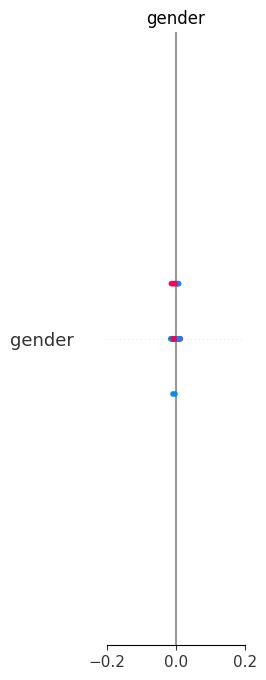

In [20]:
# Ensure X_test is in float format
X_test = X_test.astype(float)

# Wrap the model’s predict function to use in SHAP
explainer = shap.KernelExplainer(lambda x: advanced_model.predict(x), X_test)

# Calculate SHAP values for a sample of the data
shap_values = explainer.shap_values(X_test[:50])

# Visualize feature importance with SHAP
shap.summary_plot(shap_values, X_test[:50], plot_type="bar")


In [22]:
# Save the model in HDF5 format
advanced_model.save('/mnt/data/customer_churn_model.h5')



In [23]:
import numpy as np

# Convert SHAP values to a NumPy array for easier saving
shap_values_array = np.array(shap_values)

# Save SHAP values as a NumPy file
np.save('/mnt/data/shap_values.npy', shap_values_array)
